# About: Simple YARN job for Test

---

YARN, HDFSの動作確認として、Piを実行してみる。

## *Operation Note*

*This is a cell for your own recording.  ここに経緯を記述*

# Notebookと環境のBinding

Inventory中のgroup名でBind対象を指示する。

In [1]:
target_group = 'hadoop_all_testcluster'

# MapReduceサンプルジョブの実行

クライアントマシン(`hadoop_client`グループのもの)で、 `yarn jar /usr/hdp/current/hadoop-mapreduce-client/hadoop-mapreduce-examples.jar pi 10 1000` のように実行してみる。

In [2]:
import tempfile
work_dir = tempfile.mkdtemp()
work_dir

'/tmp/tmpgwiJOL'

In [4]:
import os
yarn_result = os.path.join(work_dir, 'yarn-result')

In [5]:
!ansible -a "yarn jar /usr/hdp/current/hadoop-mapreduce-client/hadoop-mapreduce-examples.jar pi 10 1000" -l { target_group } hadoop_client \
         | tee {yarn_result}

XXX.XXX.XXX.72 | SUCCESS | rc=0 >>
Number of Maps  = 10
Samples per Map = 1000
Wrote input for Map #0
Wrote input for Map #1
Wrote input for Map #2
Wrote input for Map #3
Wrote input for Map #4
Wrote input for Map #5
Wrote input for Map #6
Wrote input for Map #7
Wrote input for Map #8
Wrote input for Map #9
Starting Job
Job Finished in 29.128 seconds
Estimated value of Pi is 3.1408000000000000000016/08/19 10:36:56 INFO impl.TimelineClientImpl: Timeline service address: http://testvm003:8188/ws/v1/timeline/
16/08/19 10:36:56 INFO input.FileInputFormat: Total input paths to process : 10
16/08/19 10:36:57 INFO mapreduce.JobSubmitter: number of splits:10
16/08/19 10:36:57 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1471559811619_0002
16/08/19 10:36:58 INFO client.YARNRunner: Number of stages: 2
16/08/19 10:36:59 INFO client.TezClient: Tez Client Version: [ component=tez-api, version=XXX.XXX.XXX.2.4.2.0-258, revision=fa554fdce4e3495e09a310e0a32bb34ccc5946ad, SCM-URL=scm:git:

# 実行経過の確認

## ログの確認

ログは、 `yarn logs` コマンドにより確認することができる。この際、Application IDが必要。この情報はログから確認することができる。

In [9]:
yarn_application_id = None
with open(yarn_result, 'r') as f:
    for line in f:
        if 'Submitting DAG application with id' in line:
            yarn_application_id = line.split()[-1]
assert(yarn_application_id is not None)
yarn_application_id

'application_1471559811619_0002'

ログを確認してみる。

In [11]:
!ansible -a 'yarn logs -applicationId {yarn_application_id}' -l { target_group } hadoop_client

XXX.XXX.XXX.72 | SUCCESS | rc=0 >>


Container: container_e01_1471559811619_0002_01_000001 on testvm004_45454
LogType:dag_1471559811619_0002_1.dot
Log Upload Time:Fri Aug 19 10:37:30 +0900 2016
LogLength:1002
Log Contents:
digraph QuasiMonteCarlo {
graph [ label="QuasiMonteCarlo", fontsize=24, fontname=Helvetica];
node [fontsize=12, fontname=Helvetica];
edge [fontsize=9, fontcolor=blue, fontname=Arial];
"QuasiMonteCarlo.initialmap_MRInput" [ label = "initialmap[MRInput]", shape = "box" ];
"QuasiMonteCarlo.initialmap_MRInput" -> "QuasiMonteCarlo.initialmap" [ label = "Input [inputClass=MRInputLegacy,\n initializer=]" ];
"QuasiMonteCarlo.finalreduce_MROutput" [ label = "finalreduce[MROutput]", shape = "box" ];
"QuasiMonteCarlo.initialmap" [ label = "initialmap[MapProcessor]" ];
"QuasiMonteCarlo.initialmap" -> "QuasiMonteCarlo.finalreduce" [ label = "[input=OrderedPartitionedKVOutput,\n output=OrderedGroupedInputLegacy,\n dataMovement=SCATTER_GATHER,\n schedulingType=SEQUENTIAL]" ];
"Quas

## Swimlanesによる可視化

SwimlaneインストールNotebookによりTez-toolsをインストールしていれば、Swimlaneにより可視化することもできる。

In [12]:
%%writefile {work_dir}/swimlane.yml
- hosts: hadoop_swimlane
  tasks:
    - name: delete_swimlane_old_output
      become: yes
      file: path={{ swimlane_install_path }}/apache-tez-{{ swimlane_tez_version }}-src/tez-tools/swimlanes/{{ yarn_application_id }}.svg state=absent
  
    - name: create_swimlane_analyze
      shell: bash yarn-swimlanes.sh {{ yarn_application_id }}
      args:
        chdir: "{{ swimlane_install_path }}/apache-tez-{{ swimlane_tez_version }}-src/tez-tools/swimlanes/"
  
    - name: download_svg
      fetch: src={{ swimlane_install_path }}/apache-tez-{{ swimlane_tez_version }}-src/tez-tools/swimlanes/{{ yarn_application_id }}.svg dest={{ local_svg_path }} flat=yes


Writing /tmp/tmpgwiJOL/swimlane.yml


SVGは一時ディレクトリにダウンロードし、Notebookにレンダリングすることにする。

In [13]:
local_svg_path = os.path.join(work_dir, 'result.svg')

swimlaneのスクリプトを実行し、SVGファイルをダウンロードする。

In [16]:
extra_vars = ['-e yarn_application_id={}'.format(yarn_application_id), '-e local_svg_path={}'.format(local_svg_path)]
!ansible-playbook {' '.join(extra_vars)} {work_dir}/swimlane.yml -l {target_group}


PLAY [hadoop_swimlane] *********************************************************

TASK [setup] *******************************************************************
ok: [XXX.XXX.XXX.72]

TASK [delete_swimlane_old_output] **********************************************
changed: [XXX.XXX.XXX.72]

TASK [create_swimlane_analyze] *************************************************
changed: [XXX.XXX.XXX.72]

TASK [download_svg] ************************************************************
ok: [XXX.XXX.XXX.72]

PLAY RECAP *********************************************************************
XXX.XXX.XXX.72               : ok=4    changed=2    unreachable=0    failed=0   



ダウンロードしたSVGファイルをレンダリングする。

(以下にSwimlanesの出力画像が表示されない場合、JupyterのFileメニューからTrust Notebookすることで出力画像が表示されるようになります。)

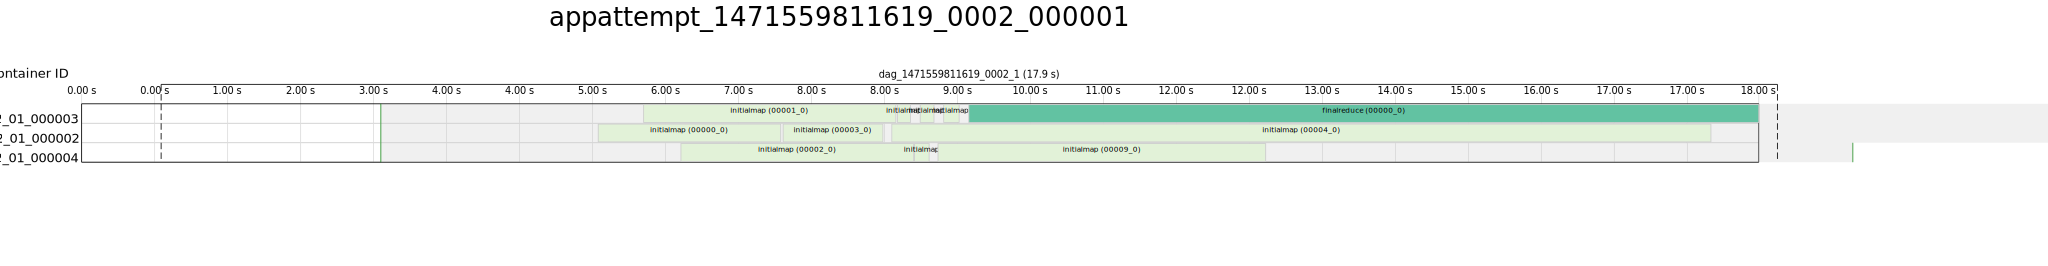

In [17]:
from IPython.display import SVG
SVG(filename=local_svg_path)

# 後始末

一時ディレクトリを削除する。

In [18]:
!rm -fr {work_dir}